Применим модель ARMA для анализа курса валют: авторегрессия (AR) + бегущее среднее (MA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,plot_predict
from statsmodels.tsa.stattools import adfuller,pacf,acf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
data = pd.read_csv("ittensive.time.series.02.csv",
                   delimiter=";", header=0, names=["Дата", "Курс", "Ипотека"])
data = data[::-1].reset_index().drop(labels="index", axis=1)
data.head()

,Дата,Курс,Ипотека
0,11.01.2022,75.1315,9.84
1,12.01.2022,74.8355,9.84
2,13.01.2022,74.5277,9.84
3,14.01.2022,74.5686,9.84
4,15.01.2022,75.7668,9.84


Исследуем автокорреляцию

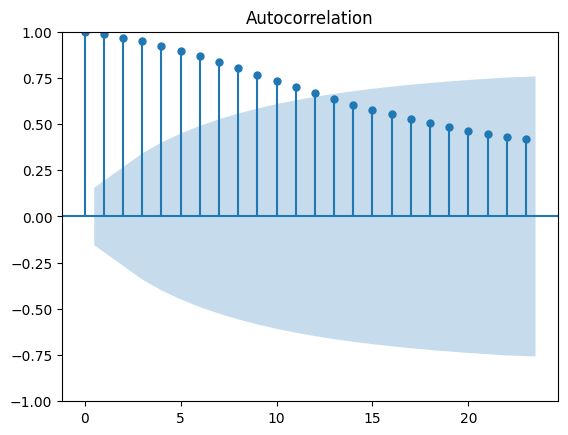

In [3]:
plot_acf(data["Курс"])
plt.show()

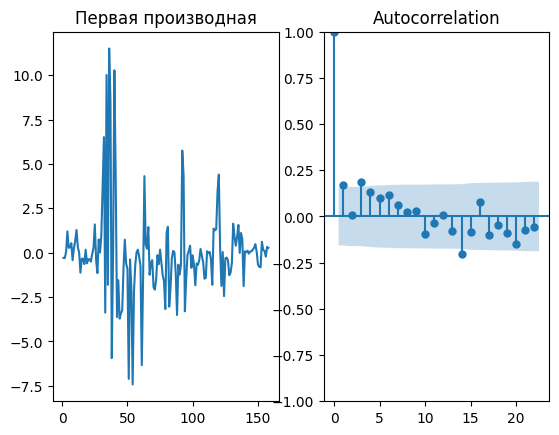

In [4]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("Первая производная")
ax1.plot(data["Курс"].diff())

ax2 = f.add_subplot(122)
plot_acf(data["Курс"].diff().dropna(), ax=ax2)
plt.show()

## Подбираем коэффициенты

Модель ARMA использует два целочисленных параметра: p и q.

* p – порядок авторегрессии (AR). Его можно интерпретировать как выражение «элемент ряда будет близок к Х, если предыдущие р элементов были близки к Х».
* q – порядок скользящего среднего (MA), который позволяет установить погрешность модели как линейную комбинацию наблюдавшихся ранее значений ошибок.

Найдем порядок автокорреляции (разностей исходного ряда)
![image.png](attachment:image.png)

In [5]:
# ищем наибольший вклад компоненты в корреляцию по первым двум производным
data_ = data["Курс"]
pacf_coeff = np.zeros(22)
for p in range(1, 3):
    data_ = data_.diff().dropna()
    pacf_coeff += np.abs(pacf(data_))
pacf_coeff = list(pacf_coeff)
p_best = pacf_coeff.index(max(pacf_coeff))+1
print ("Порядок авторегрессии (AR) равен", p_best)

Порядок авторегрессии (AR) равен 1


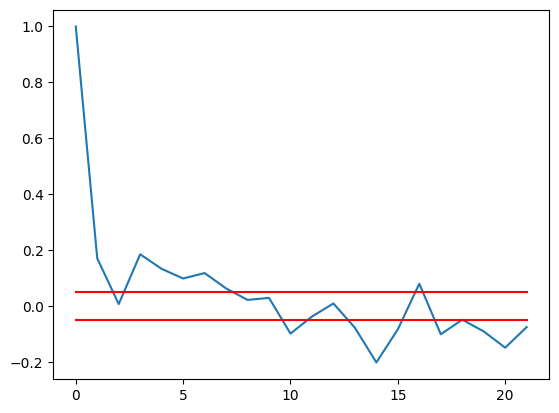

q – порядок скользящего среднего (MA) равен 2


In [6]:
# ищем порядок скользящего среднего (по вкладу компонентов первой производной)
q_best = 0
result = acf(data["Курс"].diff().dropna())
plt.plot(result)
plt.plot([0.05]*len(result), color="red")
plt.plot([-0.05]*len(result), color="red")
plt.show()
for i in range(len(result)):
    if abs(result[i]) > 0.05:
        q_best = i + 1
    else:
        break
print ("q – порядок скользящего среднего (MA) равен", q_best)

## Строим модель

In [7]:
model = ARIMA(data["Курс"], order=(p_best, 0, q_best)).fit()
print (model.summary())

                               SARIMAX Results                                
Dep. Variable:                   Курс   No. Observations:                  159
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -369.112
Date:                Thu, 16 Mar 2023   AIC                            748.224
Time:                        15:42:07   BIC                            763.568
Sample:                             0   HQIC                           754.455
                                - 159                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.3057     15.603      4.506      0.000      39.724     100.888
ar.L1          0.9803      0.013     73.680      0.000       0.954       1.006
ma.L1          0.2013      0.055      3.669      0.0

Переберем все коэффициенты "по сетке", выберем лучший вариант AIC

In [8]:
aic_best = model.aic
coeff_best = (p_best, 0, q_best)
for p in range(1,5):
    for q in range(1,5):
        model_ = ARIMA(data["Курс"], order=(p, 0, q)).fit()
        aic = model_.aic
        if aic < aic_best:
            coeff_best = (p, 0, q)
            aic_best = aic
print ("Наилучшие коффициенты:", coeff_best)

/home/roman/Python/Finance/1_PT/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/roman/Python/Finance/1_PT/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/roman/Python/Finance/1_PT/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/roman/Python/Finance/1_PT/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

Наилучшие коффициенты: (2, 0, 3)


/home/roman/Python/Finance/1_PT/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Визуализация результата

In [9]:
model = ARIMA(data["Курс"][:-10], order=(p_best, 0, q_best)).fit()
forecast = model.get_forecast(steps=10).predicted_mean

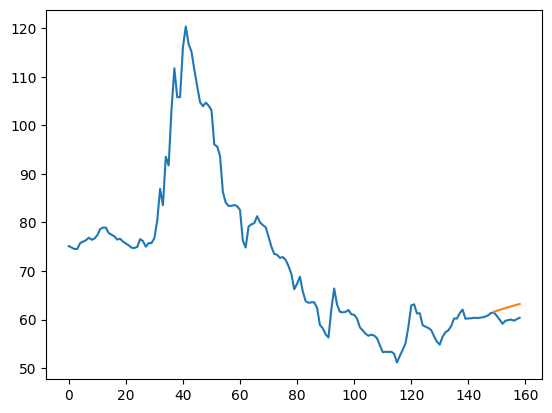

In [10]:
plt.plot(data["Курс"])
plt.plot(forecast)
plt.show()

Оценим ошибку

In [11]:
def smape(A, F):
    return 100*np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [12]:
print ("Ошибка модели:", smape(data["Курс"][-10:], forecast))

Ошибка модели: 37.91887209517145
